In [1]:
# Download data we need: If directory "data/" already exists, we'll assume the data are already downloaded.
# The files are 381 MB zipped and 1.2 GB unzipped
# Retrieving these files from NOAA takes 30-60 seconds on a home internet connection.

import os, urllib, zipfile
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import warnings
warnings.filterwarnings("ignore")

'''dir_data = '/kaggle/input/'
if not os.path.isdir(dir_data):
    os.mkdir(dir_data)

    # Zenodo URLs
    #urls = ['https://zenodo.org/record/8197443/files/public.zip?download=1',
    #        'https://zenodo.org/record/8197443/files/private.zip?download=1']
    
    # NOAA URLs (same exact data as on Zenodo) -- uncomment to download from NOAA
    urls = ['https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip',
         'https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip']

    # Download and unzip each file
    for url in urls:
        zip_path, _ = urllib.request.urlretrieve(url)
        with zipfile.ZipFile(zip_path, "r") as f:
            print('Downloaded ', url, ', now unzipping.')
            f.extractall(dir_data)

# Print list of data files:
print('\nData files for input (features) and output Dst (labels):')
for dir_pubpriv in ['noaa-public/', 'noaa-private/']:
    print(dir_data+dir_pubpriv)
    for path, dirs, files in os.walk(dir_data+dir_pubpriv): 
        for f in files: print('\t', f)'''

'dir_data = \'/kaggle/input/\'\nif not os.path.isdir(dir_data):\n    os.mkdir(dir_data)\n\n    # Zenodo URLs\n    #urls = [\'https://zenodo.org/record/8197443/files/public.zip?download=1\',\n    #        \'https://zenodo.org/record/8197443/files/private.zip?download=1\']\n    \n    # NOAA URLs (same exact data as on Zenodo) -- uncomment to download from NOAA\n    urls = [\'https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip\',\n         \'https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip\']\n\n    # Download and unzip each file\n    for url in urls:\n        zip_path, _ = urllib.request.urlretrieve(url)\n        with zipfile.ZipFile(zip_path, "r") as f:\n            print(\'Downloaded \', url, \', now unzipping.\')\n            f.extractall(dir_data)\n\n# Print list of data files:\nprint(\'\nData files for input (features) and output Dst (labels):\')\nfor dir_pubpriv in [\'noaa-public/\', \'noaa-private/\']:\n    print(dir_data+dir_pubpriv)\n    for path, dirs, files i

In [2]:
# Modules we need to get started and Matplotlib configuration:
import numpy as np, pandas as pd, pprint
import matplotlib.pyplot as plt

# The next two lines are nice for Jupyter, but not available for Colab:
#%load_ext nb_black
#%matplotlib inline

# Matplotlib Configuration
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

#### Import  Input (Features) and Output (Labels) as Pandas DataFrames
<div class="alert alert-block alert-info">
<b>Info:</b> As described above, the input data is a time series of solar wind measurements at L1 along with sunspot number, and the output data is a time series of <i>Dst</i>. Recall that for the past competition, the competitors did not have the real geophysical date/time. So here, we will recreate a new column of real geophysical date/time from our timedelta and the table shown in "Data Summary".
</div>

In [3]:
# From our time range table in the "Data Summary" section:
period_ranges = {
    'period_1':[pd.Timestamp('1998/2/16 00:00:00'), pd.Timestamp('2001/5/31  23:59:00')],
    'period_2':[pd.Timestamp('2013/6/1  00:00:00'), pd.Timestamp('2019/5/31  23:59:00')],
    'period_3':[pd.Timestamp('2004/5/1  00:00:00'), pd.Timestamp('2010/12/31 23:59:00')],
    'period_4' :[pd.Timestamp('2001/6/1  00:00:00'), pd.Timestamp('2004/4/30  23:59:00')],
    'period_5' :[pd.Timestamp('2011/1/1  00:00:00'), pd.Timestamp('2013/5/31  23:59:00')],
    'period_6' :[pd.Timestamp('2019/6/1  00:00:00'), pd.Timestamp('2020/10/31 23:59:00')]}

def convert_timedelta_to_datetime( df ):
    """Adds real geophysical datetimes to our DataFrame using the original "index" timestamps.
    
    The relative "index" timestamps were used in the MagNet competition datasets since all of the data
    were in the public domain.
    
    Parameters
    ----------
    df: pd.DataFrame
        Includes index time
    
    Returns
    -------
    df_datetimes: pd.DataFrame
        Adds datetimes to the input pd.DataFrame
    """
    df_datetimes = pd.DataFrame(index=df.index)
    df_datetimes['datetime'] = pd.NaT     # like Numpy NaN

    i = 0
    for period_name, timedelta in df.index:
        start_time = period_ranges[period_name][0]
        datetime = timedelta + start_time                 # add Pandas Timedelta to Pandas Timestamp
        df_datetimes['datetime'].values[i] = datetime
        i += 1

        #print('%s: %s + %s = %s' % (period_name, timedelta, start_time, df['datetime'].values[i]))

    return df_datetimes

In [4]:
# Assuming you have your DataFrame as df
# Create a dictionary to map the old values to the new ones
mapping = {
    'train_a': 'period_1',
    'train_b': 'period_2',
    'train_c': 'period_3',
    'test_a': 'period_4',
    'test_b': 'period_5',
    'test_c': 'period_6',
    # Add more mappings for other train types if needed
}

In [5]:
# Import as Pandas DataFrames
from pathlib import Path
DATA_PATH = Path("/kaggle/input/noaa-public/")

print('Reading in the Dst output data...')
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst['period'] = dst['period'].map(mapping)
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots['period'] = sunspots['period'].map(mapping)
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind['period'] = solar_wind['period'].map(mapping)
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions['period'] = satellite_positions['period'].map(mapping)
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)


Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


In [6]:
# Real Event Data that was previously held back from the competitors
DATA_PATH2 = Path("/kaggle/input/noaa-private/")
print('Importing data from: %s' % DATA_PATH)

print('Reading in the Dst output data...')
dst2 = pd.read_csv(DATA_PATH2 / "dst_labels.csv")
dst2['period'] = dst2['period'].map(mapping)
dst2.timedelta = pd.to_timedelta(dst2.timedelta)
dst2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots2 = pd.read_csv(DATA_PATH2 / "sunspots.csv")
sunspots2['period'] = sunspots2['period'].map(mapping)
sunspots2.timedelta = pd.to_timedelta(sunspots2.timedelta)
sunspots2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind2 = pd.read_csv(DATA_PATH2 / "solar_wind.csv")
solar_wind2['period'] = solar_wind2['period'].map(mapping)
solar_wind2.timedelta = pd.to_timedelta(solar_wind2.timedelta)
solar_wind2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions2 = pd.read_csv(DATA_PATH2 / "satellite_positions.csv")
satellite_positions2['period'] = satellite_positions2['period'].map(mapping)
satellite_positions2.timedelta = pd.to_timedelta(satellite_positions2.timedelta)
satellite_positions2.set_index(["period", "timedelta"], inplace=True)

Importing data from: /kaggle/input/noaa-public
Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


In [7]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period   timedelta           
period_1 0 days 00:00:00   -7
         0 days 01:00:00  -10
         0 days 02:00:00  -10
         0 days 03:00:00   -6
         0 days 04:00:00   -2

In [8]:
dst.groupby("period").describe()

dst                                                    
            count       mean        std    min   25%   50%  75%   max
period                                                               
period_1  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
period_2  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
period_3  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [9]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period   timedelta                                                             
period_1 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
         0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
         0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
         0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
         0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                          by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period   timedelta                                                            
period_1 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
         0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
         0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
         0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
         0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                           speed  temperature source  
period   timedelta                                    
period_1 0 days 00:00:00  383.92     110237.0     ac  
         0 days 00:01:00  381.79     123825.0     ac  
         0 days 00:02:00  389.11      82548.0     ac  
         0 days 00:03:00  389.11      82548.0     ac  
         0 days 00:04:00  384.26      94269.0     ac

In [10]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period   timedelta              
period_1 0 days             65.4
         13 days            72.0
         44 days            76.9
         74 days            80.8
         105 days           85.4

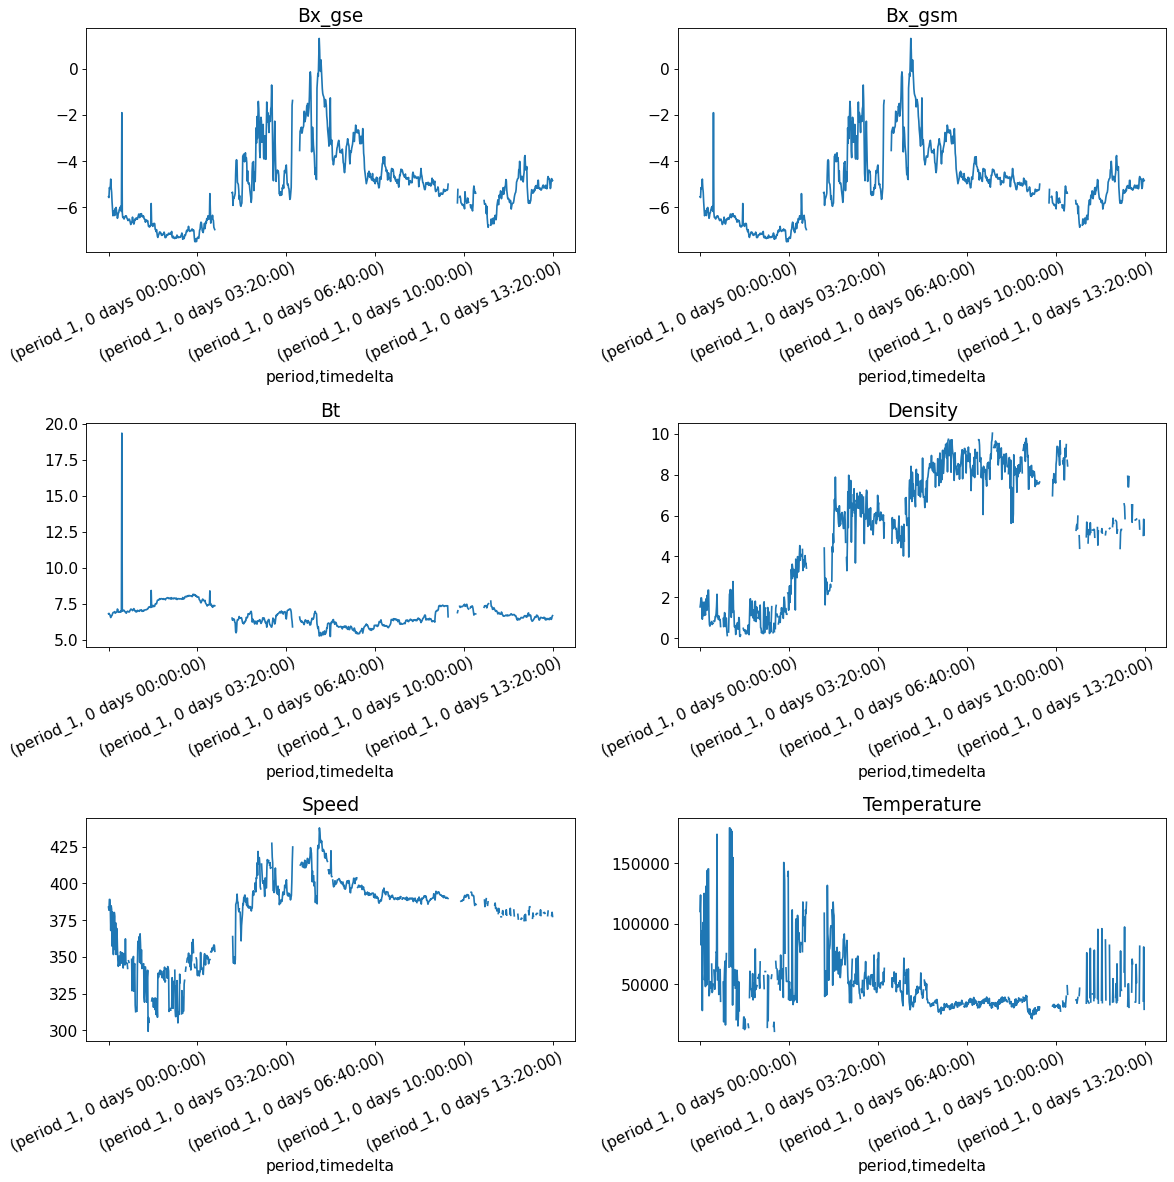

In [11]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [12]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [13]:
solar_wind.join(sunspots).join(dst)

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period   timedelta                                                        
period_1 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37   
         0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91   
         0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04   
         0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17   
         0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72   
...                             ...     ...     ...        ...      ...   
period_3 2435 days 23:55:00   -1.18    2.00   -3.92     -59.28   120.51   
         2435 days 23:56:00   -1.34    2.12   -3.83     -56.78   122.23   
         2435 days 23:57:00   -1.62    2.33   -3.63     -51.98   124.76   
         2435 days 23:58:00   -2.27    2.48   -3.22     -43.81   132.50   
         2435 days 23:59:00   -2.15    2.41   -3.30     -45.55   131.76   

                             bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period   timedelta                                                              
period_1 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37  6.80   
         0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91  6.83   
         0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04  6.77   
         0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17  6.74   
         0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72  6.65   
...                             ...     ...     ...        ...      ...   ...   
period_3 2435 days 23:55:00   -1.17    2.98   -3.23     -45.24   111.48  4.56   
         2435 days 23:56:00   -1.33    3.08   -3.12     -42.95   113.45  4.58   
         2435 days 23:57:00   -1.61    3.22   -2.87     -38.57   116.58  4.61   
         2435 days 23:58:00   -2.26    3.25   -2.44     -31.61   124.81  4.65   
         2435 days 23:59:00   -2.15    3.21   -2.53     -33.21   123.75  4.62   

                             density   speed  temperature source  \
period   timedelta                                                 
period_1 0 days 00:00:00        1.53  383.92     110237.0     ac   
         0 days 00:01:00        1.69  381.79     123825.0     ac   
         0 days 00:02:00        1.97  389.11      82548.0     ac   
         0 days 00:03:00        1.97  389.11      82548.0     ac   
         0 days 00:04:00        1.77  384.26      94269.0     ac   
...                              ...     ...          ...    ...   
period_3 2435 days 23:55:00     4.64  348.73      23368.0     ac   
         2435 days 23:56:00     4.27  346.36      26497.0     ac   
         2435 days 23:57:00     3.95  344.12      27050.0     ac   
         2435 days 23:58:00     2.81  338.52      33257.0     ac   
         2435 days 23:59:00     2.30  342.31      32267.0     ac   

                             smoothed_ssn  dst  
period   timedelta                              
period_1 0 days 00:00:00             65.4 -7.0  
         0 days 00:01:00              NaN  NaN  
         0 days 00:02:00              NaN  NaN  
         0 days 00:03:00              NaN  NaN  
         0 days 00:04:00              NaN  NaN  
...                                   ...  ...  
period_3 2435 days 23:55:00           NaN  NaN  
         2435 days 23:56:00           NaN  NaN  
         2435 days 23:57:00           NaN  NaN  
         2435 days 23:58:00           NaN  NaN  
         2435 days 23:59:00           NaN  NaN  

[8392320 rows x 17 columns]

In [14]:
solar_wind2.join(sunspots).join(dst)

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period   timedelta                                                       
period_4 0 days 00:00:00     -3.35    3.44   -1.01     -11.91   134.18   
         0 days 00:01:00     -2.98    3.59   -1.04     -12.52   129.71   
         0 days 00:02:00     -3.29    3.46   -1.04     -12.33   133.54   
         0 days 00:03:00     -3.39    3.44   -0.79      -9.29   134.57   
         0 days 00:04:00     -3.28    3.52   -0.86     -10.13   132.99   
...                            ...     ...     ...        ...      ...   
period_6 518 days 23:55:00   -3.35   -2.14    2.85      35.69   212.55   
         518 days 23:56:00   -2.39    0.21    1.45      31.07   174.91   
         518 days 23:57:00   -0.78    2.75   -0.39      -7.73   105.85   
         518 days 23:58:00   -0.23    3.71   -0.93     -14.01    93.58   
         518 days 23:59:00    0.12    3.97   -0.17      -2.47    88.26   

                            bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period   timedelta                                                             
period_4 0 days 00:00:00     -3.35    3.59    0.14       1.65   133.00  4.91   
         0 days 00:01:00     -2.98    3.73    0.17       1.98   128.61  4.78   
         0 days 00:02:00     -3.29    3.62    0.12       1.34   132.29  4.89   
         0 days 00:03:00     -3.39    3.51    0.35       4.09   133.97  4.89   
         0 days 00:04:00     -3.28    3.61    0.31       3.59   132.26  4.88   
...                            ...     ...     ...        ...      ...   ...   
period_6 518 days 23:55:00   -3.35   -1.64    3.16      40.32   206.13  4.89   
         518 days 23:56:00   -2.39    0.45    1.39      29.78   169.42  3.01   
         518 days 23:57:00   -0.78    2.65   -0.83     -16.78   106.42  2.96   
         518 days 23:58:00   -0.23    3.51   -1.52     -23.43    93.78  3.86   
         518 days 23:59:00    0.12    3.89   -0.82     -11.91    88.23  3.98   

                            density   speed  temperature source  smoothed_ssn  \
period   timedelta                                                              
period_4 0 days 00:00:00       5.57  338.59      41313.0     ac           NaN   
         0 days 00:01:00       5.66  339.11      37388.0     ac           NaN   
         0 days 00:02:00       4.95  337.70      35715.0     ac           NaN   
         0 days 00:03:00       4.96  338.41      38214.0     ac           NaN   
         0 days 00:04:00       5.35  336.63      40458.0     ac           NaN   
...                             ...     ...          ...    ...           ...   
period_6 518 days 23:55:00     4.64  388.30     111784.0     ds           NaN   
         518 days 23:56:00     5.35  390.90     123559.0     ds           NaN   
         518 days 23:57:00     5.63  411.60     120740.0     ds           NaN   
         518 days 23:58:00     5.65  416.60     100777.0     ds           NaN   
         518 days 23:59:00     5.93  415.80      89069.0     ds           NaN   

                            dst  
period   timedelta               
period_4 0 days 00:00:00    NaN  
         0 days 00:01:00    NaN  
         0 days 00:02:00    NaN  
         0 days 00:03:00    NaN  
         0 days 00:04:00    NaN  
...                         ...  
period_6 518 days 23:55:00  NaN  
         518 days 23:56:00  NaN  
         518 days 23:57:00  NaN  
         518 days 23:58:00  NaN  
         518 days 23:59:00  NaN  

[3551040 rows x 17 columns]

In [15]:
solar_wind.drop('source',axis=1, inplace=True)
solar_wind2.drop('source',axis=1, inplace=True)

### Feature Relationships

Data gaps in the Solar Wind data are a common issue with real-time data

<div class="alert alert-block alert-warning">
<b>Be Aware:</b> Gaps in our input (features) are something we'll need to deal carefully with, i.e. in the preprocessing steps below.
</div>

In [16]:
import plotly.express as px

In [17]:
correlation = solar_wind.join(sunspots).join(dst).fillna(method="bfill").corr()

fig = px.imshow(correlation, color_continuous_scale="Blues")
fig.update_layout(height=700)
fig.show()

<div class="alert alert-block alert-info">
<b>Info: </b>There are several challenges when working with these "operational" observations of the solar wind we will need to solve before modeling (e.g. missing data).
</div>

### Feature Generation

#### Set seeds for reproducibility

In [18]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

#### Feature / Input Data we'll use to Train the Model

<div class="alert alert-block alert-info">
<b>Info: </b> It's good to think about what features we'd recommend for use in developing our model. An additional exercise at the end of this notebook has learners try different sets of features. You can do so simply by adjusting the "SOLAR_WIND_FEATURES" list below. 
</div>

In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler,power_transform
from sklearn.impute import  SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PowerTransformer
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "phi_gse",
    "theta_gse",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "phi_gsm",
    "theta_gsm",
    "speed",
    "density",
]

In [20]:
# The model will be built on feature statistics, mean and standard deviation
# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

<div class="alert alert-block alert-info">
<b>Info: </b>As discussed above, we'll need to fill in gaps and create statistical summaries (hourly means and standard deviations) of our features before modeling. The following routines provide this "preprocessing" functionality of gap filling, and scaling by features' statistics.
</div>

In [21]:
from sklearn.preprocessing import StandardScaler

def impute_features(feature_df, imp = None):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # missing solar wind values imputation using most-frequent strategy
    feature_df=feature_df.reset_index()
    cols = feature_df.columns[2:]
    if imp == None:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(feature_df[cols])
    temp = imp.transform(feature_df[cols])
    feature_df[cols] = temp
    feature_df.timedelta = pd.to_timedelta(feature_df.timedelta)
    feature_df.set_index(["period", "timedelta"], inplace=True)
    return feature_df , imp


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None,imputer=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
    # aggregate solar wind data and join with sunspots
    
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed, imp = impute_features(normalized,imputer)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler, imp

In [22]:
features, scaler, imputer = preprocess_features(solar_wind, sunspots , subset=SOLAR_WIND_FEATURES)
print(features.shape)
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()
features.head()

(139872, 29)


bt_mean    bt_std  temperature_mean  \
period   timedelta                                               
period_1 0 days 00:00:00  0.499705  2.443614         -0.375267   
         0 days 01:00:00  0.547177 -0.224580         -0.479430   
         0 days 02:00:00  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.599207   -0.381502   
         0 days 01:00:00         0.953178    -1.757995   -0.867747   
         0 days 02:00:00        -0.192518    -1.912116   -1.114317   
         0 days 03:00:00         0.325491    -1.809045   -0.783042   
         0 days 04:00:00         0.201600    -1.338802   -0.484910   

                          by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period   timedelta                                                           
period_1 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
         0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
         0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
         0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
         0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                          ...  bz_gsm_std  phi_gsm_mean  phi_gsm_std  \
period   timedelta        ...                                          
period_1 0 days 00:00:00  ...   -0.645095     -0.368627    -0.720724   
         0 days 01:00:00  ...   -0.511040     -0.255717    -0.752218   
         0 days 02:00:00  ...   -0.870482     -0.254145    -0.868503   
         0 days 03:00:00  ...   -0.282789     -0.049648    -0.638287   
         0 days 04:00:00  ...   -0.471111     -0.238606    -0.387514   

                          theta_gsm_mean  theta_gsm_std  speed_mean  \
period   timedelta                                                    
period_1 0 days 00:00:00        0.247927      -1.144826   -0.738546   
         0 days 01:00:00        0.358697      -1.052803   -0.986904   
         0 days 02:00:00        0.576426      -1.392092   -1.013548   
         0 days 03:00:00        0.466099      -0.902858   -0.826469   
         0 days 04:00:00        0.442384      -0.906160   -0.601238   

                          speed_std  density_mean  density_std  smoothed_ssn  
period   timedelta                                                            
period_1 0 days 00:00:00   0.862524     -0.775827    -0.205724      0.139444  
         0 days 01:00:00   0.995063     -0.861692    -0.058215      0.139444  
         0 days 02:00:00   0.554085     -0.846222    -0.220012      0.139444  
         0 days 03:00:00  -0.211185     -0.404306     0.218373      0.139444  
         0 days 04:00:00   1.016033     -0.371487     0.097253      0.139444  

[5 rows x 29 columns]

In [23]:
features2, scaler2, imputer2 = preprocess_features(solar_wind2, sunspots2 , subset=SOLAR_WIND_FEATURES)
print(features2.shape)
# check to make sure missing values are filled
assert (features2.isna().sum() == 0).all()
features2.head()

(59184, 29)


bt_mean    bt_std  temperature_mean  \
period   timedelta                                               
period_4 0 days 00:00:00 -0.311506 -0.166852         -0.670084   
         0 days 01:00:00 -0.257180 -0.121644         -0.633529   
         0 days 02:00:00 -0.113797 -0.179912         -0.626987   
         0 days 03:00:00  0.007134 -0.614577         -0.627023   
         0 days 04:00:00 -0.042030 -0.260113         -0.553776   

                          temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                   
period_4 0 days 00:00:00        -0.546331    -0.758075   -0.583824   
         0 days 01:00:00        -0.547793    -0.788477   -0.357912   
         0 days 02:00:00        -0.484512    -1.043192   -0.444493   
         0 days 03:00:00        -0.582198    -1.176432   -0.991267   
         0 days 04:00:00        -0.488325    -1.217805   -0.620529   

                          by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period   timedelta                                                           
period_4 0 days 00:00:00     0.905309   -0.281836    -0.151684   -0.259802   
         0 days 01:00:00     0.690187   -0.521750    -0.809125   -0.538097   
         0 days 02:00:00     0.844946   -0.416686    -0.025320   -0.180539   
         0 days 03:00:00     0.914057   -0.984871     0.195880   -0.893710   
         0 days 04:00:00     0.697673   -0.624028     0.137243   -0.289184   

                          ...  bz_gsm_std  phi_gsm_mean  phi_gsm_std  \
period   timedelta        ...                                          
period_4 0 days 00:00:00  ...   -0.088773     -0.826343    -0.709726   
         0 days 01:00:00  ...   -0.446676     -0.800849    -0.719798   
         0 days 02:00:00  ...   -0.101880     -0.702358    -0.728157   
         0 days 03:00:00  ...   -0.895758     -0.678802    -0.875398   
         0 days 04:00:00  ...   -0.275533     -0.588621    -0.792026   

                          theta_gsm_mean  theta_gsm_std  speed_mean  \
period   timedelta                                                    
period_4 0 days 00:00:00        0.223992      -0.038655   -0.908184   
         0 days 01:00:00       -0.723351      -0.492674   -0.941623   
         0 days 02:00:00        0.220241      -0.221288   -0.950062   
         0 days 03:00:00        0.420327      -1.307216   -0.988391   
         0 days 04:00:00        0.294754      -0.468178   -1.082263   

                          speed_std  density_mean  density_std  smoothed_ssn  
period   timedelta                                                            
period_4 0 days 00:00:00  -0.619373      0.360563    -0.284825      1.416715  
         0 days 01:00:00  -0.752956      0.369791    -0.250942      1.416715  
         0 days 02:00:00  -0.702432      0.389097    -0.189137      1.416715  
         0 days 03:00:00  -0.852211      0.219304    -0.342911      1.416715  
         0 days 04:00:00  -0.355499      0.280538     0.013268      1.416715  

[5 rows x 29 columns]

<div class="alert alert-block alert-info">
<b>Info:</b> We also need to prepare our output (labels), i.e. our space weather storm index <i>Dst</i>, which is already a time series with an hourly cadence. The modeling task is to predict <i>Dst</i> at hour t0 and the next hour t1.
</div>

In [24]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    """Create dst[t0] (current time) and dst[t1] (next hour) labels and group by training periods.
    
    This is needed because we wish to train the model on predicting Dst at the current time (t0)
    and for the next hour (t1). The method is a simple Pandas DataFrame array timeshift from dst[0:] to get dst[1:].
    
    Parameters
    ----------
    dst : pd.DataFrame
    
    Returns
    -------
    y : pd.DataFrame
        New copy of dst pd.DataFrame now including shifted Dst, and is grouped by training period.
        This is what we will train the model on.
    """

    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift( 0)
    y["t1"] = y.groupby("period").dst.shift(-1)
    return y[YCOLS]


labels = process_labels(dst)
labels.head(n=5)

t0    t1
period   timedelta                
period_1 0 days 00:00:00  -7 -10.0
         0 days 01:00:00 -10 -10.0
         0 days 02:00:00 -10  -6.0
         0 days 03:00:00  -6  -2.0
         0 days 04:00:00  -2   3.0

In [25]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                         
period_1 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
         0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
         0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.599207   -0.381502   
         0 days 01:00:00         0.953178    -1.757995   -0.867747   
         0 days 02:00:00        -0.192518    -1.912116   -1.114317   
         0 days 03:00:00         0.325491    -1.809045   -0.783042   
         0 days 04:00:00         0.201600    -1.338802   -0.484910   

                          by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period   timedelta                                 ...               
period_1 0 days 00:00:00     0.419516    0.031658  ...   -0.645095   
         0 days 01:00:00     0.179257   -0.272971  ...   -0.511040   
         0 days 02:00:00     0.183266   -0.822786  ...   -0.870482   
         0 days 03:00:00    -0.378111    0.341156  ...   -0.282789   
         0 days 04:00:00     0.072745    1.023019  ...   -0.471111   

                          phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period   timedelta                                                    
period_1 0 days 00:00:00     -0.368627    -0.720724        0.247927   
         0 days 01:00:00     -0.255717    -0.752218        0.358697   
         0 days 02:00:00     -0.254145    -0.868503        0.576426   
         0 days 03:00:00     -0.049648    -0.638287        0.466099   
         0 days 04:00:00     -0.238606    -0.387514        0.442384   

                          theta_gsm_std  speed_mean  speed_std  density_mean  \
period   timedelta                                                             
period_1 0 days 00:00:00      -1.144826   -0.738546   0.862524     -0.775827   
         0 days 01:00:00      -1.052803   -0.986904   0.995063     -0.861692   
         0 days 02:00:00      -1.392092   -1.013548   0.554085     -0.846222   
         0 days 03:00:00      -0.902858   -0.826469  -0.211185     -0.404306   
         0 days 04:00:00      -0.906160   -0.601238   1.016033     -0.371487   

                          density_std  smoothed_ssn  
period   timedelta                                   
period_1 0 days 00:00:00    -0.205724      0.139444  
         0 days 01:00:00    -0.058215      0.139444  
         0 days 02:00:00    -0.220012      0.139444  
         0 days 03:00:00     0.218373      0.139444  
         0 days 04:00:00     0.097253      0.139444  

[5 rows x 31 columns]

In [26]:
labels2 = process_labels(dst2)
data2 = labels2.join(features2)

<div class="alert alert-block alert-info">
<b>Tip:</b> For convenience, join our processed solar wind hourly inputs (features) and our <i>Dst</i> (labels) into one Pandas DataFrame.
</div>

### Splitting the Data

<div class="alert alert-block alert-info">
<b>Info:</b> We'll split our features and labels into Training, Testing and Validation sets for each of the 3 training periods, named train_a, train_b, train_c (see Data Summary for additional details).
</div>

In [27]:
data = pd.concat([data, data2], axis=0)

In [28]:
def get_train_test_val(data, test_ratio, val_ratio):
    """Splits data across periods into train, test, and validation"""
    # Group by 'period' and calculate the sizes for each period
    period_sizes = data.groupby("period").size().reset_index(name="period_size")

    # Initialize empty DataFrames for test, validation, and train
    test = pd.DataFrame()
    val = pd.DataFrame()
    train = pd.DataFrame()

    # Iterate through 'periods' and select rows based on calculated sizes
    for _, period_data in data.groupby("period"):
        period_size = period_data.shape[0]
        
        # Calculate the number of rows for test and validation based on ratios
        test_size = int(period_size * test_ratio)
        val_size = int(period_size * val_ratio)
        
        # Split the period data into test, validation, and train
        test_data = period_data.iloc[-test_size:]
        val_data = period_data.iloc[-(test_size + val_size):-test_size]
        train_data = period_data.iloc[:-(test_size + val_size)]
        
        # Append the period data to their respective DataFrames
        test = pd.concat([test, test_data], axis=0)
        val = pd.concat([val, val_data], axis=0)
        train = pd.concat([train, train_data], axis=0)

    return train, test, val

# Example usage: Specify test and validation ratios as percentages (e.g., 20% and 10%)
train, test, val = get_train_test_val(data, test_ratio=0.20, val_ratio=0.10)

In [29]:
print(train.shape)
train.head()

(139345, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                         
period_1 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
         0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
         0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.599207   -0.381502   
         0 days 01:00:00         0.953178    -1.757995   -0.867747   
         0 days 02:00:00        -0.192518    -1.912116   -1.114317   
         0 days 03:00:00         0.325491    -1.809045   -0.783042   
         0 days 04:00:00         0.201600    -1.338802   -0.484910   

                          by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period   timedelta                                 ...               
period_1 0 days 00:00:00     0.419516    0.031658  ...   -0.645095   
         0 days 01:00:00     0.179257   -0.272971  ...   -0.511040   
         0 days 02:00:00     0.183266   -0.822786  ...   -0.870482   
         0 days 03:00:00    -0.378111    0.341156  ...   -0.282789   
         0 days 04:00:00     0.072745    1.023019  ...   -0.471111   

                          phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period   timedelta                                                    
period_1 0 days 00:00:00     -0.368627    -0.720724        0.247927   
         0 days 01:00:00     -0.255717    -0.752218        0.358697   
         0 days 02:00:00     -0.254145    -0.868503        0.576426   
         0 days 03:00:00     -0.049648    -0.638287        0.466099   
         0 days 04:00:00     -0.238606    -0.387514        0.442384   

                          theta_gsm_std  speed_mean  speed_std  density_mean  \
period   timedelta                                                             
period_1 0 days 00:00:00      -1.144826   -0.738546   0.862524     -0.775827   
         0 days 01:00:00      -1.052803   -0.986904   0.995063     -0.861692   
         0 days 02:00:00      -1.392092   -1.013548   0.554085     -0.846222   
         0 days 03:00:00      -0.902858   -0.826469  -0.211185     -0.404306   
         0 days 04:00:00      -0.906160   -0.601238   1.016033     -0.371487   

                          density_std  smoothed_ssn  
period   timedelta                                   
period_1 0 days 00:00:00    -0.205724      0.139444  
         0 days 01:00:00    -0.058215      0.139444  
         0 days 02:00:00    -0.220012      0.139444  
         0 days 03:00:00     0.218373      0.139444  
         0 days 04:00:00     0.097253      0.139444  

[5 rows x 31 columns]

In [30]:
print(val.shape)
val.head()

(19903, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                           
period_1 840 days 18:00:00 -13 -15.0  1.392218 -0.231998         -0.832243   
         840 days 19:00:00 -15  -6.0  1.504970  1.572159         -0.773590   
         840 days 20:00:00  -6   9.0  2.048136 -0.050704         -0.712973   
         840 days 21:00:00   9  20.0  2.508049  2.677117         -0.564033   
         840 days 22:00:00  20   6.0  2.553991  1.178737         -0.675644   

                            temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                     
period_1 840 days 18:00:00        -0.625576    -0.884078    0.285414   
         840 days 19:00:00        -0.564179    -0.879848    1.287067   
         840 days 20:00:00        -0.575063    -0.651535    0.498747   
         840 days 21:00:00        -0.420665     0.872849    6.276877   
         840 days 22:00:00        -0.525714     1.924273   -0.133028   

                            by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period   timedelta                                   ...               
period_1 840 days 18:00:00     1.474438   -0.048371  ...   -0.383008   
         840 days 19:00:00     1.534754   -0.140105  ...    0.561548   
         840 days 20:00:00     1.765263   -0.647165  ...   -0.282333   
         840 days 21:00:00    -0.534821    6.111959  ...    2.469630   
         840 days 22:00:00    -1.818021    0.001195  ...    0.130254   

                            phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period   timedelta                                                      
period_1 840 days 18:00:00     -0.787407    -0.799271        2.005099   
         840 days 19:00:00     -0.847741    -0.322274        1.991707   
         840 days 20:00:00     -0.874038    -0.718242        2.357104   
         840 days 21:00:00      0.586102     1.361119        1.292750   
         840 days 22:00:00      1.383672    -0.822934        1.223966   

                            theta_gsm_std  speed_mean  speed_std  \
period   timedelta                                                 
period_1 840 days 18:00:00      -0.479153    0.121181  -0.326359   
         840 days 19:00:00      -0.235218    0.153219  -0.154259   
         840 days 20:00:00      -0.781155    0.153394  -0.268117   
         840 days 21:00:00       1.139054    0.219035  -0.015680   
         840 days 22:00:00      -0.930094    0.271681  -0.536797   

                            density_mean  density_std  smoothed_ssn  
period   timedelta                                                   
period_1 840 days 18:00:00      1.350632     1.186279      2.187904  
         840 days 19:00:00      2.494491     4.208981      2.187904  
         840 days 20:00:00      4.638751     0.792717      2.187904  
         840 days 21:00:00      7.002139     6.488986      2.187904  
         840 days 22:00:00      4.318423     2.724134      2.187904  

[5 rows x 31 columns]

In [31]:
print(test.shape)
test.head()

(39808, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                           
period_1 960 days 20:00:00 -42 -36.0  3.721392 -0.276146         -0.898855   
         960 days 21:00:00 -36 -32.0  3.647589 -0.582626         -0.893382   
         960 days 22:00:00 -32 -26.0  3.554503 -0.406087         -0.806288   
         960 days 23:00:00 -26 -31.0  3.318674 -0.342302         -0.845912   
         961 days 00:00:00 -31 -26.0  3.085467 -0.217864         -0.873295   

                            temperature_std  bx_gse_mean  bx_gse_std  \
period   timedelta                                                     
period_1 960 days 20:00:00        -0.667413     1.147641   -0.312073   
         960 days 21:00:00        -0.652453     1.751483   -0.501351   
         960 days 22:00:00        -0.576025     2.031769   -0.807005   
         960 days 23:00:00        -0.561678     2.041638   -0.731824   
         961 days 00:00:00        -0.649855     1.975566   -0.723039   

                            by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period   timedelta                                   ...               
period_1 960 days 20:00:00     2.269149   -0.472095  ...   -0.423557   
         960 days 21:00:00     2.460299   -0.604943  ...   -0.732245   
         960 days 22:00:00     3.326760    0.702298  ...    1.384880   
         960 days 23:00:00     3.749649   -0.759848  ...    0.327249   
         961 days 00:00:00     3.663641   -0.674483  ...   -0.467830   

                            phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period   timedelta                                                      
period_1 960 days 20:00:00     -1.530279    -0.846173        1.583567   
         960 days 21:00:00     -1.641616    -0.866932        1.403545   
         960 days 22:00:00     -1.646178    -0.868388        0.711872   
         960 days 23:00:00     -1.635896    -0.893628        0.061490   
         961 days 00:00:00     -1.638989    -0.877468       -0.148152   

                            theta_gsm_std  speed_mean  speed_std  \
period   timedelta                                                 
period_1 960 days 20:00:00      -1.307269   -0.457723  -0.657542   
         960 days 21:00:00      -1.399662   -0.366080  -0.231337   
         960 days 22:00:00      -0.502942   -0.144989  -0.202363   
         960 days 23:00:00      -1.004689   -0.107399  -0.601914   
         961 days 00:00:00      -1.326300   -0.081434  -0.616191   

                            density_mean  density_std  smoothed_ssn  
period   timedelta                                                   
period_1 960 days 20:00:00      0.973881    -0.062592      2.046631  
         960 days 21:00:00      0.910748     0.146483      2.046631  
         960 days 22:00:00      1.446090     1.696120      2.046631  
         960 days 23:00:00      0.396158     0.122446      2.046631  
         961 days 00:00:00      0.666683    -0.151687      2.046631  

[5 rows x 31 columns]

### Load a Pre-Trained Model

#### Load Model, Scaler, History and Configuration

<div class="alert alert-block alert-success">
    <b>Exercise:</b> Choose from the following pre-trained models developed in the <b>Chapter 1</b> notebook.
</div>

<div class="alert alert-block alert-warning">
<b>Be Aware: </b>The smallest model size option in the <b>Chapter 1</b> notebook is set for notebook execution speed and training will not fully converge. In this notebook it's recommended that you load a model from <b>Chapter 1</b> that's at least as performant as the MagNet benchmark case for convergence and benchmark performance. 
</div>

In [32]:
from keras import preprocessing
import tensorflow as tf

data_config = {
    "timesteps": 128,
    "batch_size": 768,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
            shuffle=True,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])
test_ds  = timeseries_dataset_from_df(test,  data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")
print(f"Number of test batches: {len(test_ds)}")

Number of train batches: 181
Number of val batches: 27
Number of test batches: 53


## Model Development

In [33]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import models, layers, optimizers, metrics

In [34]:
model = models.Sequential()
model.add(layers.Input(shape=(data_config["timesteps"], len(XCOLS))))

model.add(layers.TimeDistributed(
    layers.Dense(32, activation='relu')
))
model.add(layers.Conv1D(32, 12, activation='relu', padding='same'))
model.add(layers.Conv1D(32, 12, activation='relu', padding='same'))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(32, 16, activation='relu', padding='same'))
model.add(layers.Conv1D(32, 16, activation='relu', padding='same'))
model.add(layers.MaxPool1D(2))
model.add(layers.TimeDistributed(
    layers.Dense(32, activation='relu')
))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(YCOLS)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 128, 32)          960       
 ibuted)                                                         
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           12320     
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 32)           12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 32)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 32)            16416     
                                                                 
 conv1d_3 (Conv1D)           (None, 64, 32)            1

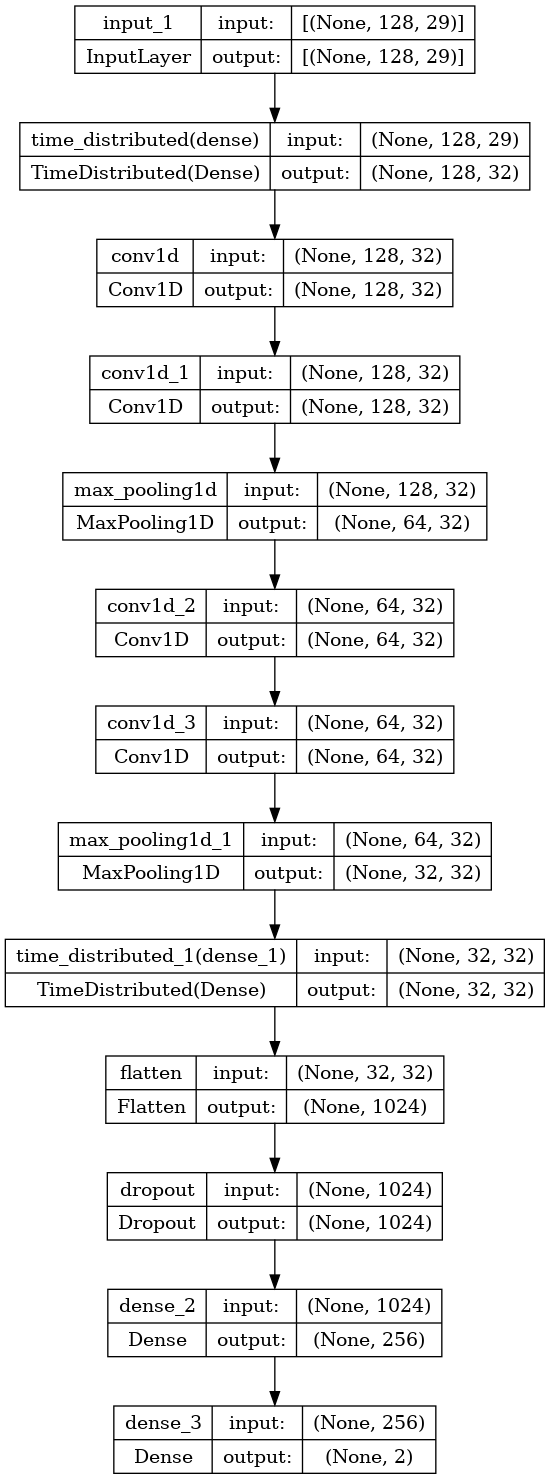

In [35]:
tf.keras.utils.plot_model(model, to_file = 'nasc_model.png', show_shapes=True, show_layer_names = True)

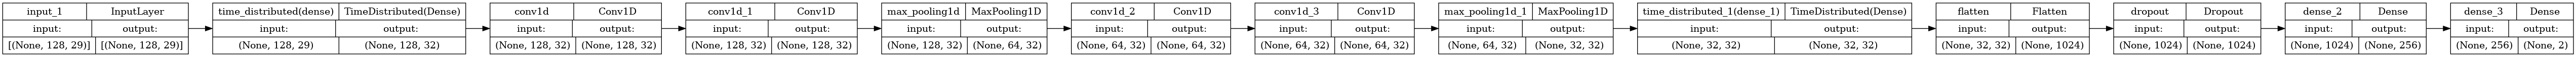

In [52]:
tf.keras.utils.plot_model(model, to_file = 'nasc_model2.png', show_shapes=True, rankdir="LR")

In [36]:
class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR
        
model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-10,
    mode='min'
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=0
)

# Compile the model
learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(
    loss=RMSE,
    optimizer=optimizer
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs = 100,
    callbacks=[checkpoint, lr_reducer],
    shuffle=True,
    validation_data=val_ds,
)

Epoch 1/100
181/181 [==============================] - 42s 160ms/step - loss: 12.6571 - val_loss: 11.4964 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - 29s 153ms/step - loss: 10.2371 - val_loss: 11.9488 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - 29s 153ms/step - loss: 9.5744 - val_loss: 11.7550 - lr: 0.0010
Epoch 4/100
181/181 [==============================] - 29s 155ms/step - loss: 9.0898 - val_loss: 11.4698 - lr: 0.0010
Epoch 5/100
181/181 [==============================] - 27s 143ms/step - loss: 8.6612 - val_loss: 10.3751 - lr: 0.0010
Epoch 6/100
181/181 [==============================] - 26s 139ms/step - loss: 8.2631 - val_loss: 10.6520 - lr: 0.0010
Epoch 7/100
181/181 [==============================] - 26s 140ms/step - loss: 7.7487 - val_loss: 10.3488 - lr: 0.0010
Epoch 8/100
181/181 [==============================] - 28s 150ms/step - loss: 7.4889 - val_loss: 10.2110 - lr: 0.0010
Epoch 9/100
181/181 [==============================] -

In [38]:
import plotly.graph_objects as go

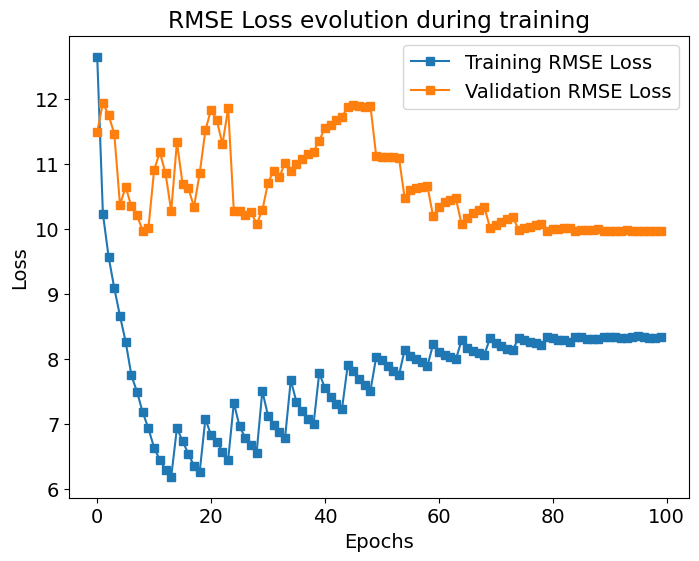

In [39]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], 's-', label='Training RMSE Loss')
    plt.plot(r.history['val_loss'], 's-', label='Validation RMSE Loss')
    plt.title('RMSE Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss.png')
    
    
plot_learning_evolution(history)

In [40]:
model.load_weights(model_path)

In [41]:
rmse = model.evaluate(test_ds)
print(f"Test RMSE: {rmse:.2f} nano-Tesla")

53/53 [==============================] - 7s 110ms/step - loss: 9.4150
Test RMSE: 9.42 nano-Tesla


In [42]:
import pandas as pd

# Assuming you have a variable named 'X_test' containing your test data
# You can use model.predict to get the predictions
predictions = model.predict(test_ds)

# Create a DataFrame for the predictions
predicted_df = pd.DataFrame(predictions, columns=['t0', 't1'])

# Display the DataFrame
print(predicted_df)


53/53 [==============================] - 6s 101ms/step
              t0         t1
0     -17.127161 -16.717966
1      -4.481908  -4.448802
2     -92.527252 -94.955673
3       4.132772   4.218189
4      -4.448812  -4.497086
...          ...        ...
38273  -4.866686  -4.937758
38274   3.976091   3.672679
38275  -6.860155  -7.172352
38276   3.460045   3.173282
38277  -1.197503  -1.479216

[38278 rows x 2 columns]


In [43]:
# Assuming you have a DataFrame named 'predicted_df' containing your predicted values
# You can specify the desired CSV file path
csv_file_path = 'predicted_values.csv'

# Use the to_csv method to save the DataFrame as a CSV file
predicted_df.to_csv(csv_file_path, index=False)

## XAI (Permutation Importance)

In [44]:
# Note: We shouldn't need these two lines below but they seem needed generalizing to run w/o
#       issues on both Colaboratory (Python 3.7) and Jupyter server with Python 3.9.
#       Contact POCs if you get an error such as:
#            AttributeError: module 'keras.preprocessing' has no attribute 'timeseries_dataset_from_array'
import tensorflow.keras as keras
from keras import preprocessing

# A couple of ways to learn about the contents of a BatchDataset:
#   print(list(test_ds.as_numpy_iterator()))
#   type(test_ds)

rmse_permute_df = pd.DataFrame(np.zeros((1,len(XCOLS))), columns=XCOLS)
for fname in XCOLS:

    # We're going to edit this data so make a deep copy of our preprocessed training dataset.
    test_for_permute = test.copy(deep=True)

    # Approximate split permutation by simply reversing the data in this feature
    test_for_permute[fname].values[:] = test_for_permute[fname].values[::-1]

    # create TensorFlow BatchDataset
    permute_ds = timeseries_dataset_from_df(test_for_permute, data_config["batch_size"])

    # evaluate model
    rmse_permute_df[fname] = model.evaluate(permute_ds)

    print('%s: %f rmse nano-Tesla' % (fname, rmse_permute_df[fname]))

53/53 [==============================] - 7s 104ms/step - loss: 10.8667
bt_mean: 10.866688 rmse nano-Tesla
53/53 [==============================] - 6s 108ms/step - loss: 9.4934
temperature_mean: 9.493414 rmse nano-Tesla
53/53 [==============================] - 6s 105ms/step - loss: 9.4114
bx_gse_mean: 9.411426 rmse nano-Tesla
53/53 [==============================] - 6s 107ms/step - loss: 9.7704
by_gse_mean: 9.770364 rmse nano-Tesla
53/53 [==============================] - 7s 105ms/step - loss: 9.6280
bz_gse_mean: 9.628011 rmse nano-Tesla
53/53 [==============================] - 7s 110ms/step - loss: 9.4613
phi_gse_mean: 9.461346 rmse nano-Tesla
53/53 [==============================] - 6s 103ms/step - loss: 10.0060
theta_gse_mean: 10.006009 rmse nano-Tesla
53/53 [==============================] - 6s 104ms/step - loss: 9.2964
bx_gsm_mean: 9.296435 rmse nano-Tesla
53/53 [==============================] - 7s 113ms/step - loss: 9.7417
by_gsm_mean: 9.741728 rmse nano-Tesla
53/53 [============

In [45]:
# Ratio the Permuted RMSE to the overall RMSE and sort in order of importance
print('In order of most important feature first to least important by rmse(j)/rmse:')
rmse_ratio_df = (rmse_permute_df/rmse).sort_values(ascending=False, by=0, axis=1)
rmse_ratio_df.T

In order of most important feature first to least important by rmse(j)/rmse:


,0
bz_gsm_mean,1.440525
speed_mean,1.330024
theta_gsm_mean,1.197792
bt_mean,1.154188
smoothed_ssn,1.077818
bz_gsm_std,1.064106
theta_gse_mean,1.062773
bt_std,1.049187
by_gsm_std,1.046571
by_gse_mean,1.037744


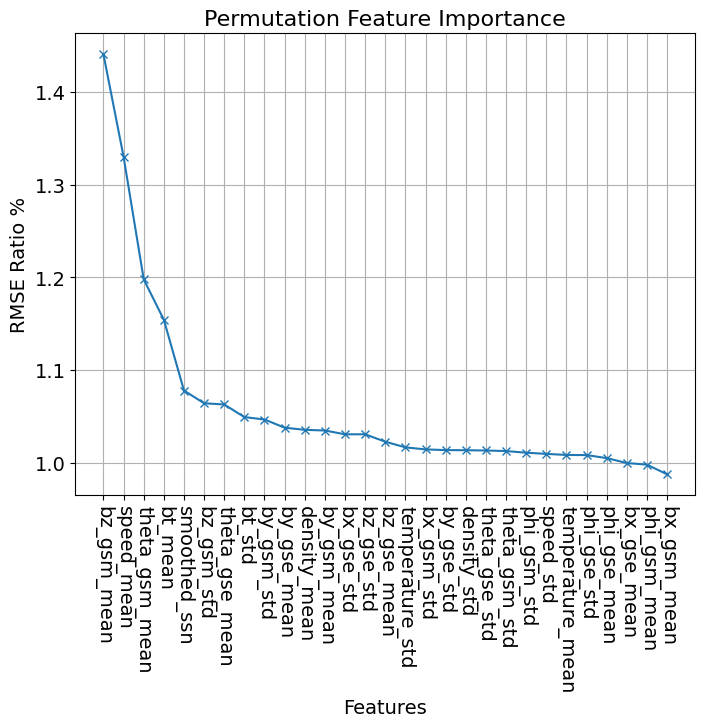

In [46]:
# Visualize the Permutation Importance outcome
plt.figure(figsize=(8, 6))
plt.plot(rmse_ratio_df.columns, rmse_ratio_df.values.T, 'x-')
plt.xticks(rotation=270)
plt.ylabel('RMSE Ratio %')
plt.xlabel('Features')
plt.title('Permutation Feature Importance', fontsize=16)
plt.grid(True)
plt.show()

# Uncomment for a Pandas barplot:
# (Note that there might be too many colors to easily interpret)
#rmse_ratio_df.plot(kind='bar', figsize=(10, 5))
#plt.title('Permutation Feature Importance')
#plt.xlim(-0.25,)
#plt.ylim(0.95, rmse_ratio_df.iloc[0,0])
#plt.grid(True)
#plt.tight_layout()

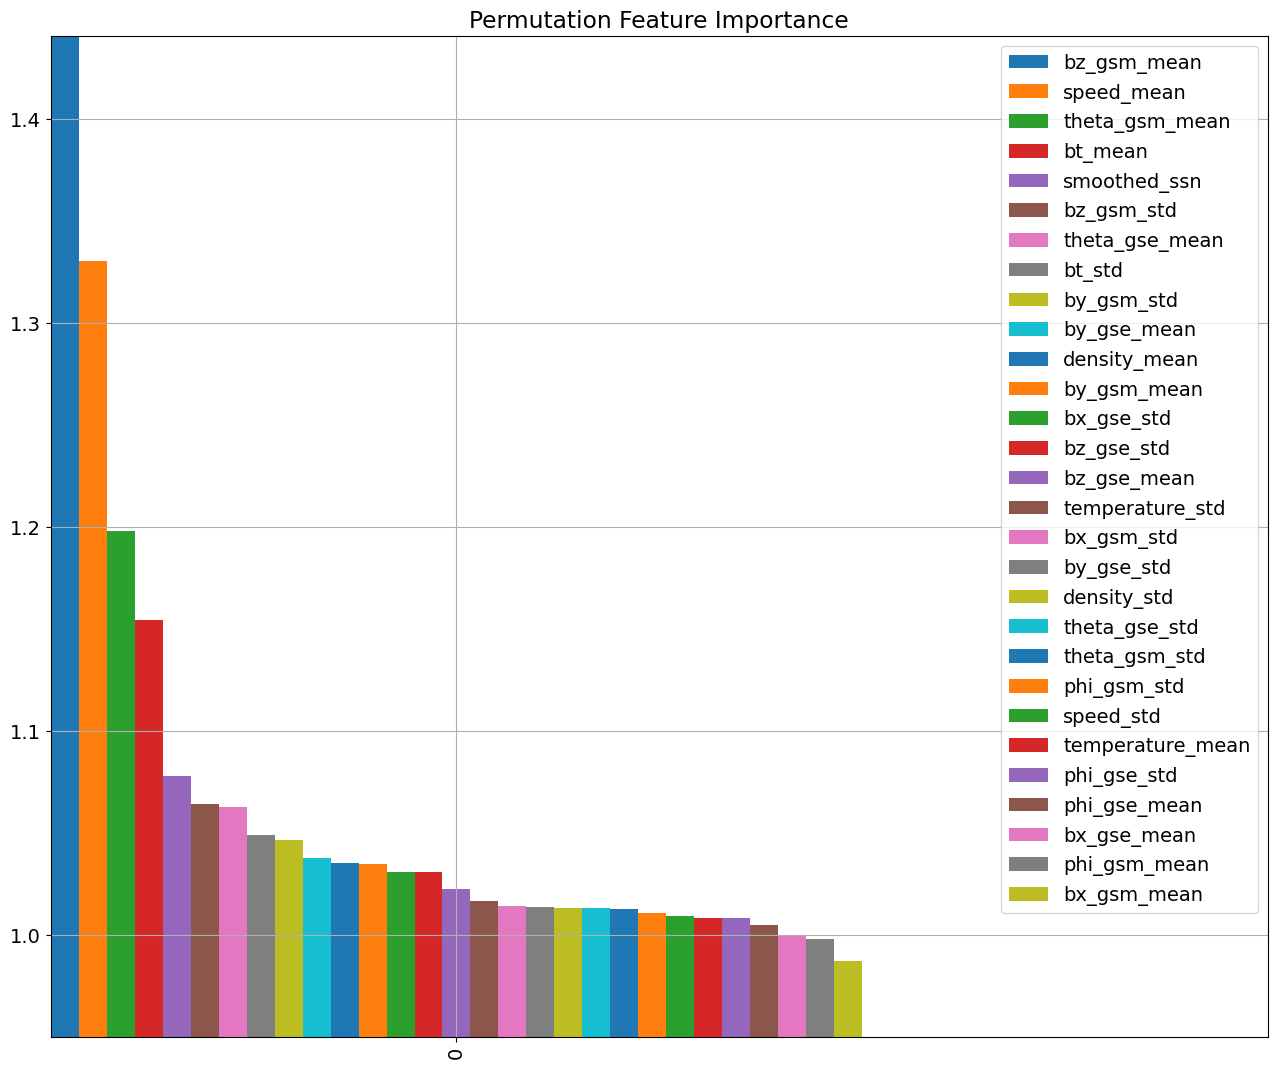

In [47]:
rmse_ratio_df.plot(kind='bar', figsize=(13, 11))
plt.title('Permutation Feature Importance')
plt.xlim(-0.25,)
plt.ylim(0.95, rmse_ratio_df.iloc[0,0])
plt.grid(True)
plt.tight_layout()

### Define Prediction Function

In [48]:
from typing import Tuple

TIMESTEPS = data_config['timesteps']

# THIS MUST BE DEFINED FOR YOUR SUBMISSION TO RUN
def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number
    
    # Process our features and grab last 128 (timesteps) hours
    features, s, i = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler,imputer = imputer, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )

    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]


    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -11
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -11

    if prediction_at_t0 > 500:
         prediction_at_t0 = 500

    if prediction_at_t0 < -2000:
         prediction_at_t0 = -2000

    if prediction_at_t1 > 500:
         prediction_at_t1 = 500

    if prediction_at_t1 < -2000:
         prediction_at_t1 = -2000
    return prediction_at_t0, prediction_at_t1

### Event: Geomagnetic storm with Dst minimum of approx. -180 nT

In [49]:
''' User Choice of Case Study Event '''
# Here we've chosen a specific event case study, you can choose different
#      case studied by looking at the sibling notebook magnet_cnn_tutorial.ipynb
#      TODO: for the correct sunspot value, currently, you have to manually peek
#            into the sunspots DataFrame and identify the closest match manually.
event_start_day = 140
latest_sunspot_number = sunspots2.iloc[5]     # The nearest match for Day 140.
''' End User Config '''

# Setup our range indices
idx_event_1day = range(event_start_day,       event_start_day       + 7      )
idx_event_1hr  = range(event_start_day*24,    event_start_day*24    + 7*24   )
idx_event_1min = range(event_start_day*24*60, event_start_day*24*60 + 7*24*60)

dst_predicted_t0 = np.nan * np.zeros(len(idx_event_1hr))
dst_predicted_t1 = np.nan * np.zeros(len(idx_event_1hr))
i_dst = 0
###idx_1min = range((event_start_day-7)*24*60, event_start_day*24*60)
for i_offset_hour in range(-7*24, 0):

    # for the
    idx_7day_1min = range(idx_event_1min[0]+i_offset_hour*60 - 1,  idx_event_1min[-1]+i_offset_hour*60 - 1)

    idx_7day_1day = range(idx_event_1day[0]+i_offset_hour//24, idx_event_1day[-1]+i_offset_hour//24)

    # Subset to 7 days around event
    solar_wind_7d_by_min          = solar_wind2.iloc[idx_7day_1min]
    satellite_positions_7d_by_day = satellite_positions2.iloc[idx_7day_1day]

    # Predict Dst
    dst_t0_t1 = predict_dst(solar_wind_7d=solar_wind_7d_by_min, satellite_positions_7d=satellite_positions_7d_by_day, latest_sunspot_number=latest_sunspot_number)

    dst_predicted_t0[i_dst] = dst_t0_t1[0]
    dst_predicted_t1[i_dst] = dst_t0_t1[1]

    i_dst += 1

    # Uncomment to see the input and output data every hour:
    #print('Hour %4d: SSN %.1f, Bz %.1f nT, V %.0f km/s, Dst [t0,t1] = [%.1f, %.1f] nT'
    #    % (i_offset_hour, latest_sunspot_number, solar_wind_7d_by_min['bz_gsm'].mean(),
    #    solar_wind_7d_by_min['speed'].mean(), dst_t0_t1[0], dst_t0_t1[1]))



1/1 [==============================] - 0s 34ms/step


In [50]:
# RMSE for this event:
#      Remember to line the indices up for observed Dst and predicted Dst[t1]
rmse_t0 = np.mean((dst2['dst'][idx_event_1hr]     - dst_predicted_t0     )**2)**0.5
rmse_t1 = np.mean((dst2['dst'][idx_event_1hr][1:] - dst_predicted_t1[:-1])**2)**0.5
print('RMSE to t0 prediction: %f nT' % rmse_t0 )
print('RMSE to t1 prediction: %f nT' % rmse_t1 )

RMSE to t0 prediction: 21.891825 nT
RMSE to t1 prediction: 21.827935 nT


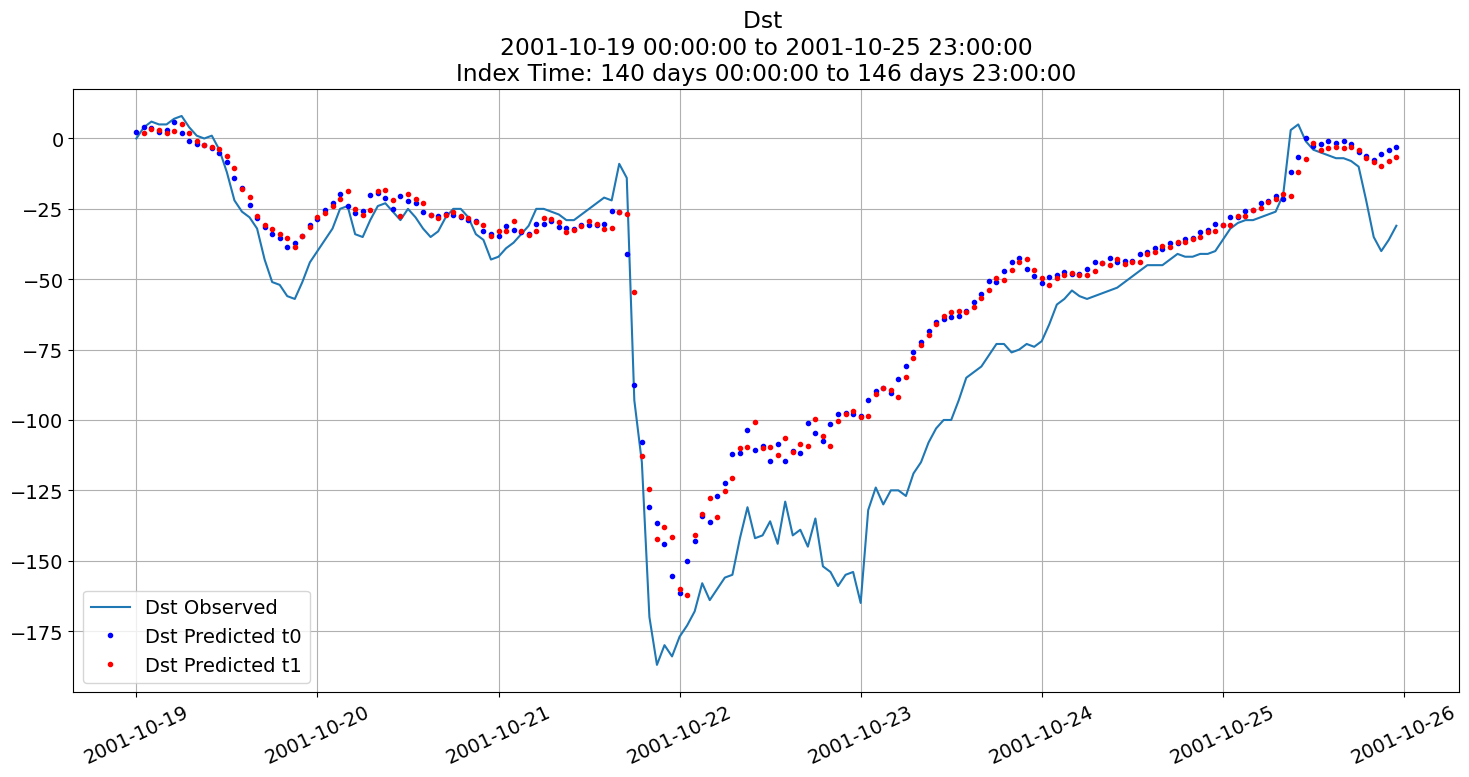

In [51]:
# Get real geophysical datetimes from our timedelta:
dst_datetime = convert_timedelta_to_datetime(dst2)
x_values = dst_datetime['datetime'][idx_event_1hr].values

# Dst Observed
title = 'Dst \n%s to %s\nIndex Time: %s to %s' % \
    (dst_datetime['datetime'][idx_event_1hr][0],
    dst_datetime['datetime'][idx_event_1hr][-1],
    dst_datetime.index[idx_event_1hr[0]][1], dst_datetime.index[idx_event_1hr[-1]][1])

fig = plt.figure(figsize=(15,8))
plt.plot( x_values, dst2['dst'][idx_event_1hr].values, label='Dst Observed')
plt.xticks(rotation=25)
plt.title( title )

# Dst Predicted at t0 and t1
#      Shift Dst[t1] to the right one hour to line up with the time axis
ax = plt.gca()
ax.plot(x_values, dst_predicted_t0, 'b.', label='Dst Predicted t0')
ax.plot(x_values, np.concatenate(([np.nan],dst_predicted_t1[:-1])), 'r.', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()